In [23]:
import xgboost as xgb
import pandas as pd
from predict import create_features
from preprocessing import get_train_test
import shap

In [24]:
DATA_DIR = "./data"
df_ce = pd.read_csv('dataframes/df_champs_elysees.csv')
df_sts = pd.read_csv('dataframes/df_saints_peres.csv')
df_conv = pd.read_csv('dataframes/df_saints_peres.csv')

df_ce['Date'] = pd.to_datetime(df_ce['Date'])
df_sts['Date'] = pd.to_datetime(df_sts['Date'])
df_conv['Date'] = pd.to_datetime(df_conv['Date'])

df_ce['Date et heure de comptage'] = pd.to_datetime(df_ce['Date et heure de comptage'])
df_sts['Date et heure de comptage'] = pd.to_datetime(df_sts['Date et heure de comptage'])
df_conv['Date et heure de comptage'] = pd.to_datetime(df_conv['Date et heure de comptage'])

In [25]:
df_train_ce, df_test_ce = get_train_test(df_ce)
df_train_sts, df_test_sts = get_train_test(df_sts)
df_train_conv, df_test_conv = get_train_test(df_conv)

## Predictions pour le débit horaire

In [26]:
X_train_ce,y_train_ce = create_features(df_train_ce,label="Débit horaire")
X_test_ce, y_test_ce = create_features(df_test_ce,label="Débit horaire")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [27]:
X_train_ce['Durée avant les prochaines vacances scolaires'] = pd.to_timedelta(X_train_ce['Durée avant les prochaines vacances scolaires']).dt.days


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
X_test_ce['Durée avant les prochaines vacances scolaires'] = pd.to_timedelta(X_test_ce['Durée avant les prochaines vacances scolaires']).dt.days


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train_ce, y_train_ce,
        eval_set=[(X_train_ce, y_train_ce), (X_test_ce, y_test_ce)],
        eval_metric='rmse',
        verbose = False)

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

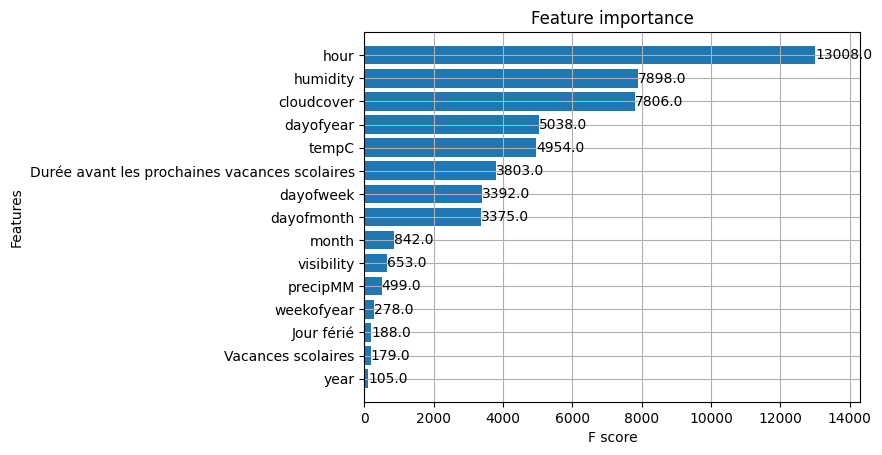

In [38]:
xgb.plot_importance(reg, height=0.8)

In [39]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test_ce)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

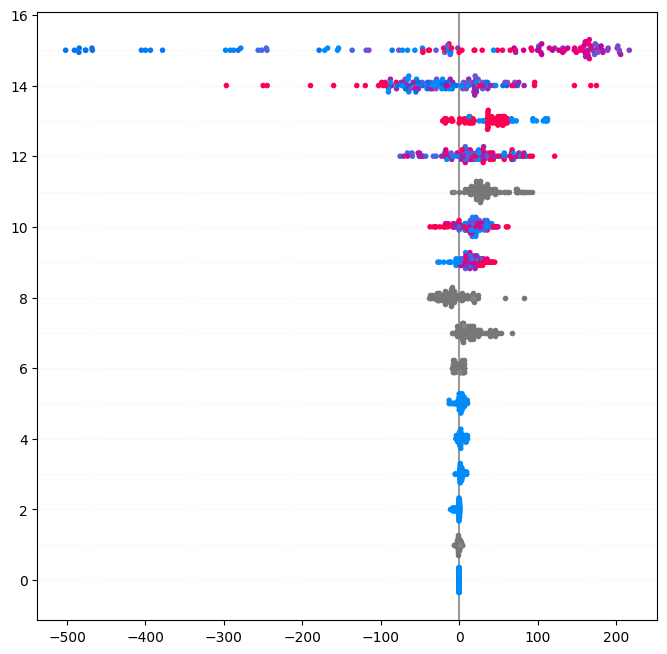

In [40]:
shap.summary_plot(shap_values, X_test_ce)

In [41]:
from sklearn.metrics import mean_squared_error
preds = reg.predict(X_test_ce)
rmse = mean_squared_error(preds,y_test_ce,squared=False)
print(f'rmse : {rmse}')

rmse : 286.8669899259219


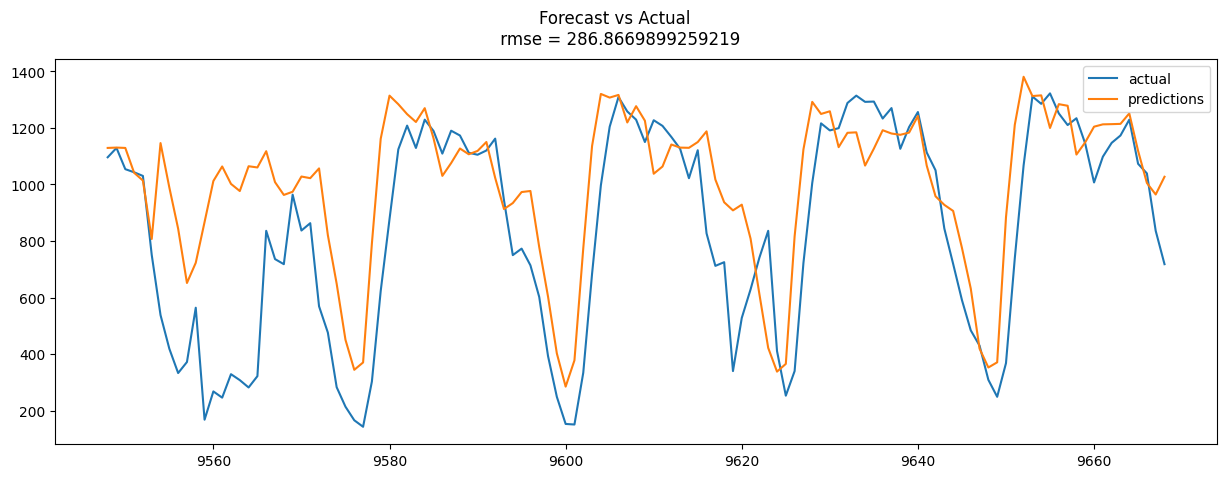

In [42]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)


y_all = pd.DataFrame({"actual":y_test_ce, "predictions":preds})

_ = y_all.plot(ax=ax)

plot = plt.suptitle('Forecast vs Actual \n rmse = {}'.format(rmse))